# MNIST dataset Image Classification

## Convolutional Neural Network with Tesorflow

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
from IPython.display import Image
%matplotlib inline

In [4]:
#First Filter in our Convolutional Neural Network
filter_size1 = 5
num_filters1 = 16

#Secound Filter in our Convolutional Neural Network
filter_size2 = 5
num_filter2 = 36

#Fully Conncted Layers(Nodes)
fc_size = 128

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Declaring out convolutional layer and filter related variables

In [6]:
#Dimensions of the data

#Size of the Image
img_size = 28

#Size of the Image when stored in one-Dimension
img_size_flat = img_size * img_size

#Shape of the Image
img_shape = (img_size,img_size)

#A Gray-Scale Image has 1 channel
#https://en.wikipedia.org/wiki/channel_(digital_image)
num_channel = 1

#Number of classes(0 to 9)
num_classes = 10

data.test.cls = np.argmax(data.test.labels,axis=1)

## Helper function for Plotting Image

In [7]:
def plot_image(image,cls_true,cls_pred=None):
    assert len(images) == len(cls_true) == 9

    
    #Creating a 3 x 3 sub-plot
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)

    for i,ax in enumerate(axes.flat):
        ax.imshow(image[i].reshape(img_shape),cmap='binary')
        
        #If predicted or not
        if cls_pred is None:
            xlabel = "True : {0}".format(cls_true[i])
        else:
            xlabel = "True : {0}, Prediction : {1}".format(cls_true[i],cls_pred[i])
            
        ax.set_xlabel(xlabel)
        
        #Removing ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

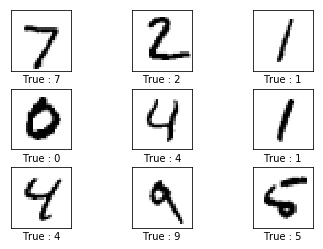

In [8]:
#Getting the first images from the Test-Set
images = data.test.images[0:9]

#Getting the True classes for those Images
cls_true = data.test.cls[0:9]

plot_image(images,cls_true)

## Tensorflow Declarations

In [9]:
def new_Weights(shape):
    #The Veriable should be in shape same as ReLu Output
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

In [10]:
def new_biases(length):
    #This is a constant value
    return tf.Variable(tf.constant(0.05,shape=[length]))

## Helper Function for Convolutional Layers

In [11]:
def new_conv_layer(input,                     #Input Data
                   num_input_chann,           #Total Input Channels
                   filter_size,               #FIlter Size
                   filter_num,                #Number of Filters
                  use_pooling=True):          #Usage of Max-Pooling (2 x 2)
    #Shape of the filter
    shape = [filter_size,filter_size,num_input_chann,filter_num]
    #Creating new Weights(Function Above)
    weights = new_Weights(shape=shape)
    #Creating new Biases
    biases = new_biases(length=filter_num)
    
    #Creating Our Tensorflow Convolutional Instance
    layer = tf.nn.conv2d(input,filter=weights,strides=[1,1,1,1],padding="SAME")
    #Adding Biases to our Layer
    layer += biases
    
    #Using Max-Pooling to downsample out Image (As because of computationally Expensive)
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
        
    #Passing the layer into rectified linear units activation function
    layer = tf.nn.relu(layer)
    
    return layer,weights

## Flattening Layer stuffs(Into 1Dimensional)

In [12]:
def flattening_layer(layer):
    #Getting the Shape of the Layer
    layer_shape = layer.get_shape()
    #Assuming the Output of the Feacture [num_images,image_height,image_width,num_channels]
    
    #Computing our total number of Feactures
    num_features = layer_shape[1:4].num_elements()
    
    #Reshaping our Layer into 1D [num_images,num_feactures]
    layer_flat = tf.reshape(layer,shape=[-1,num_features])
    
    #Now returning our flatter layer and feactures
    return layer_flat, num_features
    

## Helper function for New Fully Connected Neural Network

In [13]:
def new_fc_nn(input,num_inputs,num_outputs,use_relu=True):
    
    #Creating our Weights and Biases
    weights = new_Weights(shape=[num_inputs,num_outputs])
    biases  = new_biases(length=num_outputs)
    
    layer = tf.matmul(input,weights) + biases
    
    #Activation Function
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

### Placeholder Variables

In [14]:
x= tf.placeholder(tf.float32,name="x")
x_img = tf.reshape(x,shape=[-1,img_size,img_size,num_channel])

In [15]:
y_true = tf.placeholder(tf.float32,name="y_true")
y_true_cla = tf.argmax(y_true,dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Convolutional Layer 1

In [16]:
conv_layer1, conv_weights1 = new_conv_layer(input=x_img,
                                            num_input_chann=num_channel,
                                            filter_size=filter_size1,
                                            filter_num=num_filters1,
                                           use_pooling=True)

conv_layer1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [17]:
conv_layer2, conv_weights2 = new_conv_layer(conv_layer1,
                                            num_input_chann=num_filters1,
                                            filter_size=filter_size2,
                                            filter_num=num_filter2,
                                           use_pooling=True)

conv_layer2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer

In [18]:
layer_flat, feactures = flattening_layer(conv_layer2)
print(layer_flat)
print("Number of Feactures :",feactures)

Tensor("Reshape_1:0", shape=(?, 1764), dtype=float32)
Number of Feactures : 1764


### Fully connected Layer1

In [19]:
layer_fc1 = new_fc_nn(input=layer_flat,
                      num_inputs=feactures,
                      num_outputs=fc_size)

layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Fully Connected layer2

In [20]:
layer_fc2 = new_fc_nn(input=layer_fc1,
                      num_inputs=fc_size,
                      num_outputs=num_classes,
                     use_relu=False)

layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [21]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred,dimension=1)

### Cost-Function to be Optimized

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [23]:
#Cost Function
cost = tf.reduce_mean(cross_entropy)

In [24]:
#Optimization Methon
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [25]:
correct_pred = tf.equal(y_pred_cls,y_true_cla)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

### Tensorflow Sessions

In [26]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [27]:
traning_batch = 64

In [28]:
#Counting the total iterations Performed
total_iter = 0

def optimizerfun(num_iterations):
    global total_iter
    start_time = time.time()
    init = tf.initialize_all_variables()
    session.run(init)
    init_glob = tf.global_variables_initializer()
    session.run(init_glob)
    for i in range(total_iter,total_iter+num_iterations):
        #x_batch holdes the batch of images
        #y_true holds the true labels for those images
        x_batch,y_batch_for_batch = data.train.next_batch(traning_batch)
        
        #Feeding the data of batches into the placeholder for Training
        feed_dictinary = {x:x_batch,y_true:y_batch_for_batch}
        session.run(optimizer,feed_dict=feed_dictinary)
        
        #Printing for every 100 iterations
        if i % 100 == 0:
            #Calculating the accuracy on the Training set
            acc = session.run(accuracy,feed_dict=feed_dictinary)
            
            #Message for printing
            msg = "Optimization Iterating: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            #Printing it
            print(msg.format(i + 1, acc))
            
        #Updating the total number of Iteratings
        total_iter += num_iterations
        
        #ending the time
        end_time = time.time()
        
        #Difference in Time
        time_deff = end_time-start_time
        print("Time Usage: "+str(timedelta(seconds=int(round(time_deff)))))

### Helper function to Plot example errors

In [29]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    con_met = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    
    #Printing our confusion matrix
    print(con_met)
    
    #Plot our confusion matrix as an Image
    plt.matshow(con_met)
    
    #Making various adjustments to the plot
    plt.colorbar()
    tick_mark = np.arange(num_classes)
    plt.xticks(tick_mark,range(num_classes))
    plt.yticks(tick_mark,range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    plt.show()
    

### per function for showing performance

In [30]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_confusion_matrix:
        plot_confusion_matrix(cls_pred)

In [31]:
print_test_accuracy()

Accuracy on Test-Set: 11.3% (1133 / 10000)


In [ ]:
optimizerfun(num_iterations=10000)

# Testing out Accuracy after 10000 Iterations

In [35]:
print_test_accuracy()

Accuracy on Test-Set: 98.6% (9864 / 10000)


Accuracy on Test-Set: 98.6% (9864 / 10000)
[[ 974    0    1    0    0    2    1    1    1    0]
 [   0 1130    1    0    0    0    1    2    1    0]
 [   6    1 1015    3    1    0    0    3    3    0]
 [   1    0    0 1002    0    4    0    1    2    0]
 [   0    0    1    1  976    0    0    0    0    4]
 [   2    0    0    3    0  886    1    0    0    0]
 [   6    2    0    1    2    6  941    0    0    0]
 [   2    1    7    1    0    0    0 1016    1    0]
 [   5    0    3    2    1    6    0    3  951    3]
 [   4    5    1    4    6    4    0   10    2  973]]


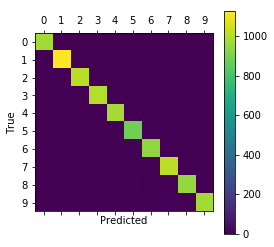

In [36]:
print_test_accuracy(show_confusion_matrix=True)

# Final Accuracy : 98.7%